In [1]:
# Import packages
import pathlib
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import pandas as pd
from skimage import exposure
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0 #MODEL B

### Data

In [2]:
train_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(5_class)/train')
valid_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(5_class)/valid')

In [3]:
# Set Image Dimension (determined by EfficientNet model choice)
IMG_SIZE = 224 # B0=224

# Set Batch Size
BATCH_SIZE = 64

# training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

# validation set
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    label_mode = 'categorical',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 3093 files belonging to 5 classes.
Found 389 files belonging to 5 classes.


In [4]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

for name in CLASS_NAMES:
    print(name)

Garden and Urban Birds
Kingfishers
Raptors
Waterbirds
Woodpeckers and Barbets


In [5]:
CLASS_NAMES

['Garden and Urban Birds',
 'Kingfishers',
 'Raptors',
 'Waterbirds',
 'Woodpeckers and Barbets']

### Model

In [31]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [32]:
model = build_model(num_classes=NUM_CLASSES)

In [33]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                       

                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization) 

                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

### Training Stage 1

In [34]:
epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, 
                 epochs = epochs, 
                 validation_data = valid_ds,
                 verbose=2)

Epoch 1/25
49/49 - 128s - loss: 0.5059 - accuracy: 0.8729 - val_loss: 0.9754 - val_accuracy: 0.6658 - 128s/epoch - 3s/step
Epoch 2/25
49/49 - 142s - loss: 0.1838 - accuracy: 0.9515 - val_loss: 0.7006 - val_accuracy: 0.7866 - 142s/epoch - 3s/step
Epoch 3/25
49/49 - 185s - loss: 0.1871 - accuracy: 0.9509 - val_loss: 0.3574 - val_accuracy: 0.8946 - 185s/epoch - 4s/step
Epoch 4/25
49/49 - 213s - loss: 0.1234 - accuracy: 0.9706 - val_loss: 0.3451 - val_accuracy: 0.9177 - 213s/epoch - 4s/step
Epoch 5/25
49/49 - 202s - loss: 0.1586 - accuracy: 0.9609 - val_loss: 0.1889 - val_accuracy: 0.9537 - 202s/epoch - 4s/step
Epoch 6/25
49/49 - 166s - loss: 0.1493 - accuracy: 0.9638 - val_loss: 0.2539 - val_accuracy: 0.9486 - 166s/epoch - 3s/step
Epoch 7/25
49/49 - 146s - loss: 0.1315 - accuracy: 0.9712 - val_loss: 0.1928 - val_accuracy: 0.9589 - 146s/epoch - 3s/step
Epoch 8/25
49/49 - 159s - loss: 0.1191 - accuracy: 0.9715 - val_loss: 0.2207 - val_accuracy: 0.9666 - 159s/epoch - 3s/step
Epoch 9/25
49/49

In [35]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

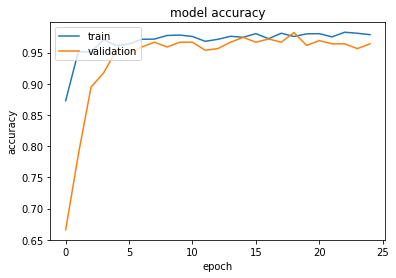

In [36]:
plot_hist(hist)

### Training Stage 2

In [37]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [38]:
unfreeze_model(model)

In [39]:
epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, 
                 epochs = epochs, 
                 validation_data = valid_ds,
                 verbose=2)

Epoch 1/10
49/49 - 91s - loss: 0.1156 - accuracy: 0.9812 - val_loss: 0.2590 - val_accuracy: 0.9717 - 91s/epoch - 2s/step
Epoch 2/10
49/49 - 86s - loss: 0.0684 - accuracy: 0.9897 - val_loss: 0.2004 - val_accuracy: 0.9717 - 86s/epoch - 2s/step
Epoch 3/10
49/49 - 87s - loss: 0.0588 - accuracy: 0.9887 - val_loss: 0.1763 - val_accuracy: 0.9743 - 87s/epoch - 2s/step
Epoch 4/10
49/49 - 88s - loss: 0.0495 - accuracy: 0.9916 - val_loss: 0.1832 - val_accuracy: 0.9743 - 88s/epoch - 2s/step
Epoch 5/10
49/49 - 87s - loss: 0.0438 - accuracy: 0.9929 - val_loss: 0.1593 - val_accuracy: 0.9769 - 87s/epoch - 2s/step
Epoch 6/10
49/49 - 87s - loss: 0.0460 - accuracy: 0.9903 - val_loss: 0.1891 - val_accuracy: 0.9692 - 87s/epoch - 2s/step
Epoch 7/10
49/49 - 87s - loss: 0.0370 - accuracy: 0.9922 - val_loss: 0.1717 - val_accuracy: 0.9666 - 87s/epoch - 2s/step
Epoch 8/10
49/49 - 89s - loss: 0.0248 - accuracy: 0.9932 - val_loss: 0.1508 - val_accuracy: 0.9717 - 89s/epoch - 2s/step
Epoch 9/10
49/49 - 88s - loss: 0

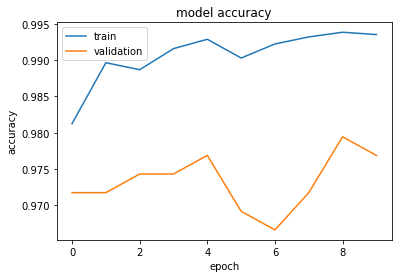

In [40]:
plot_hist(hist)

### Save Model

In [41]:
model.save('D:\\University\\CS3244\\Project\\EfficientNet\\saved_model\\model_B0ML5nad')

INFO:tensorflow:Assets written to: D:\University\CS3244\Project\EfficientNet\saved_model\model_B0ML5nad\assets


### Evaluation

In [34]:
test_dir = pathlib.Path('D:/University/CS3244/Project/EfficientNet/data - Copy/data(5_class)/test')

In [125]:
# Function to process and predict image
def image_prediction(image):
    # Process input image
    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = np.expand_dims(image_resized, axis=0)
    
    # Threshold
    threshold = (1/NUM_CLASSES) * 1.2 # 120% from uniform split probability as threshold
    
    # Run image through model to obtain prediction
    pred = model.predict(image)
        # pred is a array of length class_count. Each entry is the probability for a particular class
        # Index based on class_names
        
    if pred[0][np.argmax(pred)] < threshold:
        pred_class = "Unknown"
        
    else:    
        # Obtain prediction class
        pred_class = CLASS_NAMES[np.argmax(pred)]
    
    return pred_class

In [126]:
total_count   = [0] * NUM_CLASSES
true_positive = [0] * NUM_CLASSES
false_negative = [0] * NUM_CLASSES
false_positive = [0] * NUM_CLASSES
unknown_count = 0

for bird_folder in test_dir.rglob("*"):
    for bird_image in bird_folder.rglob("*.jpg"):
        
        bird_species = str(bird_folder.stem)
        bird_index = CLASS_NAMES.index(bird_species)
        
        # Update total count
        total_count[bird_index] += 1
        
        # Load image
        image = cv2.imread(str(bird_image))
        
        # Predict classification
        pred_class = image_prediction(image)
        # print(pred_class)
        
        if str(pred_class) == bird_species:
            true_positive[bird_index] += 1
            
        elif str(pred_class) == "Unknown":
            unknown_count += 1
            
        else:
            false_negative[bird_index] += 1  
            false_positive[CLASS_NAMES.index(pred_class)] += 1

In [127]:
unknown_count

0

In [129]:
results = pd.DataFrame({'Class': CLASS_NAMES,
                        'total': total_count,
                        'true_positive' : true_positive,
                        'false_negative' : false_negative,
                        'false_positive' : false_positive})

In [130]:
results['Precision'] = results['true_positive']/(results['true_positive']+results['false_positive'])
results['Recall'] = results['true_positive']/(results['true_positive']+results['false_negative'])
results['F1 Score'] = (2/((1/results['Precision'])+(1/results['Recall'])))

In [131]:
results

,Class,total,true_positive,false_negative,false_positive,Precision,Recall,F1 Score
0,Garden and Urban Birds,190,181,9,29,0.861905,0.952632,0.905000
1,Kingfishers,33,21,12,13,0.617647,0.636364,0.626866
2,Raptors,48,39,9,3,0.928571,0.812500,0.866667
3,Waterbirds,75,70,5,4,0.945946,0.933333,0.939597
4,Woodpeckers and Barbets,43,26,17,3,0.896552,0.604651,0.722222


In [135]:
filepath = pathlib.Path('D:/University/CS3244/Project/EfficientNet/Results CSV/test.csv') 
results.to_csv(filepath, index = False) 

In [72]:
weighted_F1_score = (sum(results['F1 Score']*results['actual_count'])/sum(results['actual_count']))*100
weighted_precision = (sum(results['Precision']*results['actual_count'])/sum(results['actual_count']))*100
weighted_recall = (sum(results['Recall']*results['actual_count'])/sum(results['actual_count']))*100

print('Weighted F1 Score: '+str(weighted_F1_score)+'%')
print('Weighted Precision: '+str(weighted_precision)+'%')
print('Weighted Recall: '+str(weighted_recall)+'%')

Weighted F1 Score: 86.63239074550128%
Weighted Precision: 86.63239074550128%
Weighted Recall: 86.63239074550128%


In [62]:
mAP = sum(results['Precision'])/NUM_CLASSES
mAP*100

59.736962649753345

In [24]:
# Reloading model from save
model = tf.keras.models.load_model('D:\\University\\CS3244\\Project\\EfficientNet\\saved_model\\model_B0ML5nad')